<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/Autoenc_MNISTlatentcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
#NEW! for doing PCA on the model output
from sklearn.decomposition import PCA

import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


Import and process the data

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')
#we'll use the labels for matching with the latent code
labels=data[:,0]
data=data[:,1:]
#normalize the data to a range of[0 1]
dataNorm=data/np.max(data)
#convert to tensor
dataT=torch.tensor(dataNorm).float()

Create the DL model

In [3]:
#create a class for the model
def createTheMNISTAE():
  class aenet(nn.Module):
    def __init__(self):
      super().__init__()
      ###input layer
      self.input = nn.Linear(784,150)
      ###encoder layer
      self.enc = nn.Linear(150,15)
      ##bottleneck layer
      self.lat = nn.Linear(15,150)
      ###decoder layer
      self.decoding = nn.Linear(150,784)
    #forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      #NEW! output the hidden-layer activation
      codex = F.relu( self.enc(x) ) # Corrected typo here
      x = F.relu( self.lat(codex) )
      y=torch.sigmoid( self.decoding(x) )
      return y,codex
      # NEW HERE:MSEloss USED
  net = aenet()
  #loss function
  lossfun = nn.MSELoss()
  #optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)
  return net,lossfun, optimizer

Create a function that trains the model

In [4]:
def function2trainTheModel():

  # number of epochs
  numepochs = 10000
  #create a new model
  net,lossfun,optimizer=createTheMNISTAE()
  #initialize losses
  losses=torch.zeros(numepochs)
  # loop over epochs
  for epochi in range(numepochs):
    #select a random set of images
    randomidx=np.random.choice(dataT.shape[0],size=32)
    X=dataT[randomidx,:]
    #forward pass and loss
    yHat=net(X)[0] #new! here only care about the final model output
    loss=lossfun(yHat,X)
    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses[epochi]=loss.item()
  return losses,net

Run the model and show the results!

Final losses:0.0157


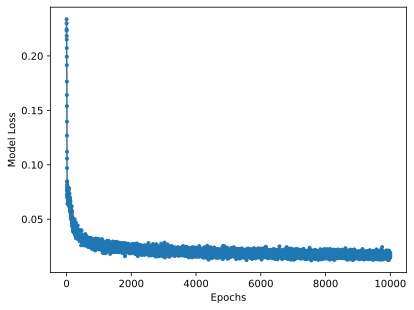

In [5]:
#train the model(16s)
losses,net=function2trainTheModel()
print(f'Final losses:{losses[-1]:.4f}')

#visualize the losses
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model Loss')
plt.show()

Inspect the latent 'code' of the model

torch.Size([20000, 784])
torch.Size([20000, 15])


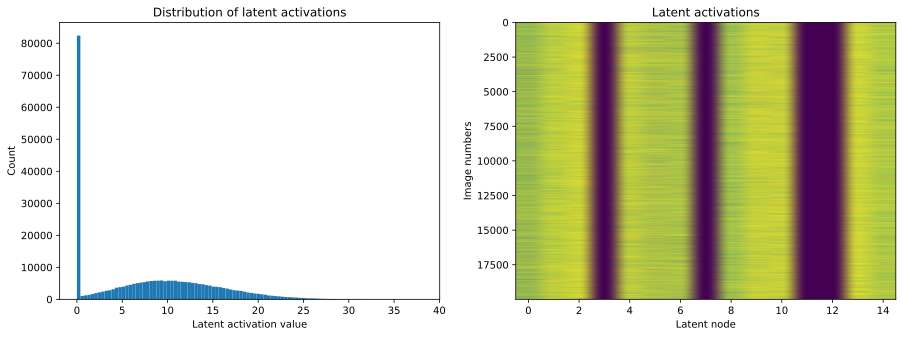

In [6]:
#output the latent layer
#push through the entire dataset
yHat,latent=net(dataT)
#print sizes
print(yHat.shape)
print(latent.shape)
#what does it look like?
fig,ax=plt.subplots(1,2,figsize=(15,5))

ax[0].hist(latent.detach().numpy().flatten(),bins=100)
ax[0].set_xlabel('Latent activation value')
ax[0].set_ylabel('Count')
ax[0].set_title('Distribution of latent activations')

ax[1].imshow(latent.detach(),aspect='auto',vmin=0,vmax=10)
ax[1].set_xlabel('Latent node')
ax[1].set_ylabel('Image numbers')
ax[1].set_title('Latent activations')
plt.show()



Something more quantitative

<ipython-input-8-a074ac94dd41>:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  sourcecode[:,i]=torch.mean(latent[digidx,:],axis=1).detach()


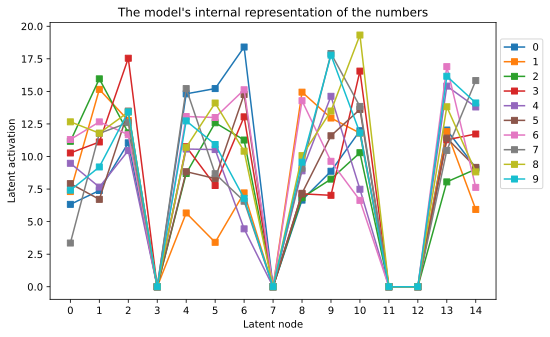

In [8]:
#compute the average latent activation for each digit type
#intialize output matrix (latent shapem by 10 digit)
sourcecode=np.zeros((latent.shape[1],10))
#loop over digit categories
for i in range(10):
  #find all pictures of this category
  digidx=np.where(labels==i)
  #average the latent layer output
  sourcecode[:,i]=torch.mean(latent[digidx,:],axis=1).detach()
#let's see what it look like
fig=plt.figure(figsize=(8,5))

plt.plot(sourcecode,'s-')
plt.legend(range(10),loc=(1.01,.4))
plt.xticks(range(15))
plt.xlabel('Latent node')
plt.ylabel('Latent activation')
plt.title("The model's internal representation of the numbers")
plt.show()

Explore the reduced-compressed space with PCA


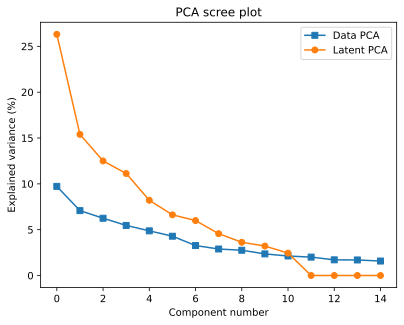

In [9]:
#compute and fit the PCA
pcaData=PCA(n_components=15).fit(data)
pcaCode = PCA(               ).fit(latent.detach())
#plot the eigen spectra (screeplot)
plt.plot(100*pcaData.explained_variance_ratio_,'s-',label='Data PCA ')
plt.plot(100*pcaCode.explained_variance_ratio_,'o-',label='Latent PCA')
plt.xlabel('Component number')
plt.ylabel('Explained variance (%)')
plt.title('PCA scree plot')
plt.legend()
plt.show()


In [10]:
#compute the projection of the data onto the PC axes
scoresData=pcaData.fit_transform(data)
scoresCode=pcaCode.fit_transform(latent.detach())
#plot the data separatly per number
fig,ax=plt.subplots(1,2,figsize=(15,5))
for lab in range(10):
  ax[0].plot(scoresData[labels==lab,0],scoresData[labels==lab,1],'o',markersize=3,alpha=.4)
  ax[1].plot(scoresCode[labels==lab,0],scoresCode[labels==lab,1],'o',markersize=3,alpha=.4)
for i in range(2):
  ax[i].set_xlabel('PC1')
  ax[i].set_ylabel('PC2')
  ax[i].legend(range(10))
ax[0].set_title('Data PCA')
ax[1].set_title('Latent PCA')
plt.show()